# 04 Simulation-Algebraic

In this chapter we discuss the principles involved in solving systems of algebraic equations. The standard form for this system can be interpreted as a vector-valued function set equation to zero vector $\mathbf{F(x)} = \mathbf{0}$. The simplest way to interpret this is as a set of simultaneous equations where each row of $\mathbf{F}$ is a scalar equation $f_i(\mathbf{x}) = 0$ which takes in multiple variables (the elements of a vector $\mathbf{x}$) and produces a scalar output. Therefore, the scalar function $f_i(\mathbf{x})$ is a mapping $f_i:\mathbb{R}^n \rightarrow \mathbb{R}$ while the complete system $F:\mathbb{R}^n \rightarrow \mathbb{R}^m$. The solution is the vector $\mathbf{x}$ which makes all equations true simultaneously.

In terms of computational methods, a method that finds the solution to $\mathbf{F(x)} = \mathbf{0}$ is called a solver. There are many different types of solvers, which can be broadly categorized into linear and non-linear solvers. Linear solvers handle the case where $\mathbf{F(x)}$ is a linear function of $\mathbf{x}$, while nonlinear solvers deal with more general cases where $\mathbf{F(x)}$ may be nonlinear. Because the non-linear case is more general (linear systems can be solved with a non-linear solver, but a non-linear system cannot be solved with a linear sovler), we will discuss it first.

As we develop each method we will give both an algebraic and geometric interpretation where possible.


## Historical Perspective
The pursuit of solving algebraic equations has deep roots in mathematics, dating back to ancient civilizations. The Babylonians (circa 2000 BC) used early forms of iterative methods to approximate square roots, akin to fixed-point iteration, which was popularized by Heron of Alexandria in his work _Metrica_ (60 AD). General purpose, modern computational approaches to root-finding began to take shape in the 16th and 17th centuries with the development of numerical methods. In the 17th century, Isaac Newton and Joseph Raphson independently developed what is now known as Newton's method (1669), which uses tangent lines to approximate roots, marking a shift toward derivative-based techniques. The 19th century saw advancements like the Gauss-Newton algorithm (1809 by Carl Friedrich Gauss), originally for least-squares problems but later generalized for nonlinear systems. Halley's method (1694 by Edmond Halley) extended Newton's by incorporating second derivatives for faster convergence. The first specialized algorithm for solving linear systems of equatiopns was the Gauss–Seidel method (due to Seidel in 1874), which is an iterative technique that refines guesses based on previous estimates.

The 20th century brought modern computational methods: trust-region techniques emerged in the 1940s (e.g., Levenberg-Marquardt in 1944/1963), addressing issues with Newton's method in poorly conditioned problems. Powell's hybrid method (1970 by Michael J. D. Powell) combined trust-region and line-search ideas for robust nonlinear solving. These developments coincided with the rise of digital computers, leading to libraries like MINPACK (1980), which influenced SciPy's optimize module. Today, SciPy provides efficient implementations of these methods, building on LAPACK and other numerical libraries.

While root-finding shares roots with optimization (e.g., finding roots by minimizing $  \|\mathbf{F(x)}\|^2  $), this chapter focuses on direct root-finding algorithms, reserving optimization details for later units.

## Intuitive geometric understanding: the parabola

The historical perspective above highlights how many root-finding (and optimization) methods are built on geometric interpretations of the original method of Newton. This has a very satisfying geometric interpretation. Imagine at any given point $x_k$ of some function $f$ you want to find a fixed point (in this case also $f=0$). One way to do this would be to find a tangent line at $x_k$: $h(x) = m x + c$ and -since you have the equation for the tangent line- set the tangent line to zero $h(x_k)=0$ so that you can find the next guess point $x_{k+1} = \frac{h(x_k) - c}{m}$ ($m$ can be found with either the first order derivative $\frac{df (x_k)}{dx}$ or a numerical approximation of it). This is the intuition behind all *gradient descent* methods. The interpretation is very simple: we expect the function to change linearly according to $h(x)$, therefore we can use $h(x)$ to predict where we expect the function $f(x)$ will be zero. The parabola $f(x) = x^2 - 2$, which has roots at $x = \pm \sqrt{2}$, is the perfect function to demonstrate the workings of the method. When the initial guess value ($x_k$) is far away from the point, the tangent line is a poor approximation of the function, and the next guess ($x_{k+1}$) may be even further away from the root. However, as the guess approaches the root, the tangent line becomes a better approximation, leading to rapid convergence (see plot below).

We can greatly improve our knowledge of the function by adding the second order derivative (the curvature) to our approximation. This tells us how much our tangent line should curve at every point $x$, improving our model of the function from $h(x)$ to quadratic approximation of the function around our guess point $x_k$. For the parabola $f(x) = a x^2 - 2$, the second derivative is constant ($\frac{d^2 f(x)}{dx^2} = 2$) for any coefficient $a$, so the quadratic approximation will always be a perfect fit as seen below:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def plot_func(x0=1.5, a=1.0, n=2.0):
    x_min = -2.0
    x_max = 8.0
    x = np.linspace(x_min, x_max, 400)
    y = a * x**n
    dy = a * n * x**(n - 1)
    ddy = a * n * (n - 1) * x**(n - 2)

    f = lambda x_val: a * x_val**n
    df = lambda x_val: a * n * x_val**(n - 1)
    ddf = lambda x_val: a * n * (n - 1) * x_val**(n - 2)

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

    # Plot f(x)
    axs[0].plot(x, y, 'k-', label=r'$f(x) = a x^n$')
    axs[0].plot(x0, f(x0), 'bo', label='Guess $x_0$')

    # Tangent line
    y_tan = f(x0) + df(x0) * (x - x0)
    axs[0].plot(x, y_tan, color='tab:red', linestyle='--', label='Tangent at $x_0$')

    # Intersection with y=0
    if abs(df(x0)) > 1e-10:
        x1 = x0 - f(x0) / df(x0)
        if x_min < x1 < x_max:
            axs[0].plot(x1, 0, 'kx', markersize=10, label='Tangent intersection X')
            y1 = f(x1)
            axs[0].plot([x1, x1], [0, y1], 'k--')
            axs[0].plot(x1, y1, 'ko', label='$f(x_1)$')

    # Quadratic approximation
    y_quad = f(x0) + df(x0) * (x - x0) + 0.5 * ddf(x0) * (x - x0)**2
    axs[0].plot(x, y_quad, color='tab:orange', linestyle='--', label='Quadratic approx')

    axs[0].set_ylabel(r'$f(x)$')
    axs[0].legend()
    axs[0].grid(True)

    # Plot df/dx
    axs[1].plot(x, dy, 'r-', label=r'$\frac{df}{dx}$')
    axs[1].plot(x0, df(x0), 'bo')
    axs[1].set_ylabel(r'$\frac{df}{dx}$')
    axs[1].legend()
    axs[1].grid(True)

    # Plot d²f/dx²
    axs[2].plot(x, ddy, color='tab:orange', linestyle='-', label=r'$\frac{d^2f}{dx^2}$')
    axs[2].plot(x0, ddf(x0), 'bo')
    axs[2].set_ylabel(r'$\frac{d^2f}{dx^2}$')
    axs[2].set_xlabel('$x$')
    axs[2].legend()
    axs[2].grid(True)

    plt.show()

interact(plot_func,
         x0=FloatSlider(min=0.1, max=8.0, step=0.1, value=6, description='Starting guess'),
         a=FloatSlider(min=-2.0, max=2.0, step=0.1, value=1.0, description='Coefficient a'),
         n=FloatSlider(min=0.5, max=5.0, step=0.1, value=2.0, description='Power n'));

interactive(children=(FloatSlider(value=6.0, description='Starting guess', max=8.0, min=0.1), FloatSlider(valu…

Of course, most functions are not second order and therefore the quadratic approximation will not be perfect. So the question might by why not use higher order approximations of the Taylor series expansion of the function:

$$ f(x) \approx f(x_k) + f'(x_k)(x - x_k) + \frac{f''(x_k)}{2!}(x - x_k)^2 + \frac{f'''(x_k)}{3!}(x - x_k)^3 + \ldots $$

etc. ? The simple answer is that higher order derivatives are often expensive to compute (especially in higher dimensions), and the added complexity does not always yield better convergence. Using higher order approximations is certainly possible and even useful for some specific cases, but they don't produce good _generalized_ methods. In practice, second order methods (like Newton's method) strike a good balance between computational cost and convergence speed for many problems. Fundamentally this is because -inside a unimodal basin of attraction- the second order approximation captures the essential curvature of the function, meaning if we are able to predict the change in the tangent locally then we can at least attempt to fully capture where the zero crossing will be in the next step based on the information we have.

## 1. General purpose non-linear solvers
In this chapter we discussed general purpose non-linear solvers which solve a nonlinear vector-valued function $\mathbf{F(x)} = \mathbf{0}$ where $\mathbf{F}$.

### 1.1 Line search family of methods

The line search family of methods are a generalization of gradient descent methods for finding roots of nonlinear equations. The basic idea is to iteratively improve an initial guess by moving in directions that reduce the residual norm $\|\mathbf{F(x)}\|$. This is typically done by combining a search direction (often derived from the Jacobian or its approximation) with a step size determined through a line search procedure. In general, a single step in the line search method can be written as:

$$\mathbf{x_{k+1}} = \mathbf{x_k} + \alpha_k \mathbf{p_k}$$

where $\mathbf{p_k}$ is is the search direction -usually based on the steepest descent or Newton direction- and $\alpha_k$ is the step size determined by the line search. The goal of the line search is to find an $\alpha_k$ that sufficiently reduces the residual norm, ensuring convergence toward a root.

### 1.2 Gauss–Newton algorithm

The prototypical numerical method -the Newton-Rhapson method- essentially picks $\alpha_k \mathbf{p_k}$ based on a tangent line approximation of $\mathbf{F(x)}$ at the current guess $\mathbf{x_k}$. Many modern algorithms are built on this foundation, including the Gauss-Newton method specific to solving non-linear systems.

Newton and Raphson's original methods were actually developed for _optimization_ (see Chapters 7-9), specifically for finding stationary points of functions. However, Gauss showed how to turn the problem of solving any set of non-linear equations into an optimization problem by minimizing the sum of squares of the residuals. The Gauss-Newton method approximates the Hessian matrix using only first derivatives (the Jacobian), making it computationally more efficient than full Newton's method for least-squares problems. In Gauss-Newton, systems of nonlinear equations $\mathbf{F}(\mathbf{x}) = \mathbf{0}$ are solved by minimizing the sum of squared residuals:

$$ S(\mathbf{x}) = \frac{1}{2} \|\mathbf{F}(\mathbf{x})\|^2_2 $$

This is particularly useful for overdetermined systems (where the number of equations $m$ exceeds the number of variables $n$), but it can also be applied to square systems ($m = n$). The method approximates the problem locally using a linear least-squares subproblem at each iteration, avoiding the need for second-order derivatives.

At this point it is useful to expand on the concepts of Jacobian and Hessian matrices, which are central to understanding the Gauss-Newton method.

### 1.3 The Jabobian and Hesisan matrices

The Jacobian and Hessian matrices are fundamental tools which we will use again and again, particularly in the context of optimization and root-finding algorithms. They can be viewed as generalizations of the derivative concept from single-variable calculus to multivariable functions. A first order derivative (Jacobian) captures how a vector-valued function changes with respect to its input variables, formally:

> **Definition:** The **Jacobian matrix** $\mathbf{J}(\mathbf{x})$ of $\mathbf{F}(\mathbf{x})$ is an $m \times n$ matrix where each entry is the partial derivative of a component of $\mathbf{F}$ with respect to a variable in $\mathbf{x}$:
>
> $$ \mathbf{J}_{ij}(\mathbf{x}) = \frac{\partial f_i(\mathbf{x})}{\partial x_j}, \quad i = 1, \dots, m, \quad j = 1, \dots, n. $$
>
> It represents the local linear approximation of $\mathbf{F}$ around $\mathbf{x}$, i.e., $\mathbf{F}(\mathbf{x} + \mathbf{\delta}) \approx \mathbf{F}(\mathbf{x}) + \mathbf{J}(\mathbf{x}) \mathbf{\delta}$.

The second order derivative (Hessian) captures how the gradient itself changes:

> **Definition:** The **Hessian matrix** $\mathbf{H}(\mathbf{x})$ for a scalar-valued function $S(\mathbf{x}): \mathbb{R}^n \to \mathbb{R}$ (e.g., the sum of squares) is an $n \times n$ symmetric matrix of second partial derivatives:
>
> $$ \mathbf{H}_{ij}(\mathbf{x}) = \frac{\partial^2 S(\mathbf{x})}{\partial x_i \partial x_j}.$$
>
> For $S(\mathbf{x}) = \frac{1}{2} \|\mathbf{F}(\mathbf{x})\|^2_2$, the exact Hessian is $\mathbf{H}(\mathbf{x}) = \mathbf{J}(\mathbf{x})^\top \mathbf{J}(\mathbf{x}) + \sum_{i=1}^m f_i(\mathbf{x}) \mathbf{H}_i(\mathbf{x})$, where $\mathbf{H}_i$ is the Hessian of $f_i$. The Gauss-Newton method approximates this by dropping the second term, yielding $\mathbf{H}(\mathbf{x}) \approx \mathbf{J}(\mathbf{x})^\top \mathbf{J}(\mathbf{x})$, which is positive semi-definite and cheaper to compute.

Before moving on to the Gauss-Newton method, it would be useful to keep abstracted functions for computing the Jacobian and Hessian matrices, as these will be used repeatedly in various algorithms and are useful to have in your toolbox in general. Below are codes for finding the matrices both analytically and numerically using finite differences.

It is important to note that we will rarely be able to find analytical solutions for the Jacobian and Hessian matrices, especially for complex functions. And often even when they are available analytically, they may be too expensive to compute directly. Therefore, numerical approximations using finite differences are commonly employed in practice.

For demonstration we consider a scalar multivariate function $f: \mathbb{R}^3 \to \mathbb{R}$, where the "Jacobian" refers to the gradient vector $\nabla f$, and the Hessian is the matrix of second partial derivatives $\mathbf{H}$. We use a 3D example function:

$$f(x_1, x_2, x_3) = x_1^2 x_2 + x_3^3 + \sin(x_1 x_2 x_3)$$


In [76]:
import sympy as sp

# Define symbols
x_1, x_2, x_3 = sp.symbols('x_1 x_2 x_3')

# Define the function
f = x_1**2 * x_2 + x_3**3 + sp.sin(x_1 * x_2 * x_3)

# Compute the Jacobian (gradient)
jacobian = sp.Matrix([f]).jacobian([x_1, x_2, x_3])
print("Jacobian (Gradient):")
sp.pprint(jacobian)

# Compute the Hessian
hessian = sp.hessian(f, (x_1, x_2, x_3))
print("\nHessian:")
sp.pprint(hessian)

# Evaluate at a point, e.g., (1, 1, 1)
point = {x_1: 1, x_2: 1, x_3: 1}
jacobian_eval = jacobian.subs(point)
hessian_eval = hessian.subs(point)
print("\nEvaluated Jacobian at (1,1,1):")
sp.pprint(jacobian_eval)
print("\nEvaluated Hessian at (1,1,1):")
sp.pprint(hessian_eval)

Jacobian (Gradient):
⎡                                 2                                            ↪
⎣2⋅x₁⋅x₂ + x₂⋅x₃⋅cos(x₁⋅x₂⋅x₃)  x₁  + x₁⋅x₃⋅cos(x₁⋅x₂⋅x₃)  x₁⋅x₂⋅cos(x₁⋅x₂⋅x₃) ↪

↪        2⎤
↪  + 3⋅x₃ ⎦

Hessian:
⎡              2   2                                            2              ↪
⎢          - x₂ ⋅x₃ ⋅sin(x₁⋅x₂⋅x₃) + 2⋅x₂             - x₁⋅x₂⋅x₃ ⋅sin(x₁⋅x₂⋅x₃ ↪
⎢                                                                              ↪
⎢          2                                                           2   2   ↪
⎢- x₁⋅x₂⋅x₃ ⋅sin(x₁⋅x₂⋅x₃) + 2⋅x₁ + x₃⋅cos(x₁⋅x₂⋅x₃)                -x₁ ⋅x₃ ⋅s ↪
⎢                                                                              ↪
⎢          2                                                 2                 ↪
⎣   - x₁⋅x₂ ⋅x₃⋅sin(x₁⋅x₂⋅x₃) + x₂⋅cos(x₁⋅x₂⋅x₃)         - x₁ ⋅x₂⋅x₃⋅sin(x₁⋅x₂ ↪

↪                                     2                                    ⎤
↪ ) + 2⋅x₁ + x₃⋅cos(x₁⋅x₂⋅x₃)  - x₁⋅x₂ ⋅x₃⋅sin(x₁⋅x₂⋅x₃)

For a nicer TeX output of the matrices you have to run the following commands in a Jupyter notebook cell one at a time:

In [77]:
jacobian_eval

Matrix([[cos(1) + 2, cos(1) + 1, cos(1) + 3]])

In [78]:
hessian

Matrix([
[                        -x_2**2*x_3**2*sin(x_1*x_2*x_3) + 2*x_2, -x_1*x_2*x_3**2*sin(x_1*x_2*x_3) + 2*x_1 + x_3*cos(x_1*x_2*x_3), -x_1*x_2**2*x_3*sin(x_1*x_2*x_3) + x_2*cos(x_1*x_2*x_3)],
[-x_1*x_2*x_3**2*sin(x_1*x_2*x_3) + 2*x_1 + x_3*cos(x_1*x_2*x_3),                                 -x_1**2*x_3**2*sin(x_1*x_2*x_3), -x_1**2*x_2*x_3*sin(x_1*x_2*x_3) + x_1*cos(x_1*x_2*x_3)],
[        -x_1*x_2**2*x_3*sin(x_1*x_2*x_3) + x_2*cos(x_1*x_2*x_3),         -x_1**2*x_2*x_3*sin(x_1*x_2*x_3) + x_1*cos(x_1*x_2*x_3),                 -x_1**2*x_2**2*sin(x_1*x_2*x_3) + 6*x_3]])

In [79]:
# Numerical approximations using finite differences
import numpy as np
import scipy

# Define the function as a callable
def f(vec):
    x, y, z = vec
    return x**2 * y + z**3 + np.sin(x * y * z)

# Numerical Jacobian (gradient) using finite differences
def numerical_jacobian(func, point, eps=1e-6):
     # This is simply forward finite difference approximation of the gradient f(x+eps) - f(x) / eps:
    return scipy.optimize.approx_fprime(point, func, eps)  # Using SciPy's built-in function for numerical gradient approximation adds some robustness

# Numerical Hessian using finite differences on the gradient
def numerical_hessian(func, point, eps=1e-6):
    n = len(point)
    hess = np.zeros((n, n))
    grad_at_point = numerical_jacobian(func, point, eps)
    for i in range(n):
        point_shifted = np.copy(point)
        point_shifted[i] += eps
        grad_shifted = numerical_jacobian(func, point_shifted, eps)
        hess[:, i] = (grad_shifted - grad_at_point) / eps
    return hess

# Evaluate at a point, e.g., [1, 1, 1]
x = np.array([1.0, 1.0, 1.0])
jac_num = numerical_jacobian(f, x)
hess_num = numerical_hessian(f, x)

print("Numerical Jacobian at [1,1,1]:")
print(jac_num)
print("\nNumerical Hessian at [1,1,1]:")
print(hess_num)

Numerical Jacobian at [1,1,1]:
[2.54030289 1.54030189 3.54030489]

Numerical Hessian at [1,1,1]:
[[ 1.15818466  1.69864123 -0.30109248]
 [ 1.69864123 -0.84199314 -0.30109248]
 [-0.30109248 -0.30109248  5.15809617]]


In [84]:
# Compare the analytical and numerical results:
print("\nAnalytical Jacobian evaluated at [1,1,1]:")
print(jacobian.subs(point).evalf())

print("\nNumerical Jacobian at [1,1,1]:")
print(jac_num)
print('-')
print("\nAnalytical Hessian evaluated at [1,1,1]:")
print(hessian.subs(point).evalf())
print("\nNumerical Hessian at [1,1,1]:")
print(hess_num)


Analytical Jacobian evaluated at [1,1,1]:
Matrix([[2.54030230586814, 1.54030230586814, 3.54030230586814]])

Numerical Jacobian at [1,1,1]:
[2.54030289 1.54030189 3.54030489]
-

Analytical Hessian evaluated at [1,1,1]:
Matrix([[1.15852901519210, 1.69883132106024, -0.301168678939757], [1.69883132106024, -0.841470984807897, -0.301168678939757], [-0.301168678939757, -0.301168678939757, 5.15852901519210]])

Numerical Hessian at [1,1,1]:
[[ 1.15818466  1.69864123 -0.30109248]
 [ 1.69864123 -0.84199314 -0.30109248]
 [-0.30109248 -0.30109248  5.15809617]]


#### Vector-valued functions

In this demonstration, we consider a vector-valued function $\mathbf{F}: \mathbb{R}^3 \to \mathbb{R}^2$, defined as:

$$\mathbf{F}(x, y, z) = \begin{bmatrix} x^2 y + z \\ \sin(x y) + z^2 \end{bmatrix}$$

The Jacobian $\mathbf{J}$ is the $2 \times 3$ matrix of first partial derivatives.
Since the Hessian is typically defined for scalar functions, we compute it for the scalar least-squares objective $S(\mathbf{x}) = \frac{1}{2} \|\mathbf{F}(\mathbf{x})\|^2_2$. The exact Hessian of $S$ is $\mathbf{J}^\top \mathbf{J} + \sum_{i=1}^2 F_i \mathbf{H}_i$, where $\mathbf{H}_i$ is the Hessian of the $i$-th component of $\mathbf{F}$. (The Gauss-Newton method approximates by dropping the second term.)

In [28]:
import sympy as sp

# Define symbols
x_1, x_2, x_3 = sp.symbols('x y z')

# Define the vector-valued function F as a Matrix
F = sp.Matrix([x_1**2 * x_2 + x_3, sp.sin(x_1 * x_2) + x_3**2])

# Compute the Jacobian
jacobian = F.jacobian([x_1, x_2, x_3])
print("Jacobian:")
sp.pprint(jacobian)

# Compute S = 1/2 * ||F||^2
S = sp.Rational(1, 2) * (F.T * F)[0]

# Compute the Hessian of S
hessian = sp.hessian(S, (x_1, x_2, x_3))
print("\nHessian of S:")
sp.pprint(hessian)

# Evaluate at a point, e.g., (1, 1, 1)
point = {x_1: 1, x_2: 1, x_3: 1}
jacobian_eval = jacobian.subs(point)
hessian_eval = hessian.subs(point)
print("\nEvaluated Jacobian at (1,1,1):")
sp.pprint(jacobian_eval)
print("\nEvaluated Hessian of S at (1,1,1):")
sp.pprint(hessian_eval)

Jacobian:
⎡                 2         ⎤
⎢  2⋅x⋅y         x        1 ⎥
⎢                           ⎥
⎣y⋅cos(x⋅y)  x⋅cos(x⋅y)  2⋅z⎦

Hessian of S:
⎡                 2  2    2 ⎛ 2           ⎞             2    2            ⎛ 2  ↪
⎢              4⋅x ⋅y  - y ⋅⎝z  + sin(x⋅y)⎠⋅sin(x⋅y) + y ⋅cos (x⋅y) + 2⋅y⋅⎝x ⋅ ↪
⎢                                                                              ↪
⎢   3         ⎛ 2           ⎞                   2            ⎛ 2      ⎞   ⎛ 2  ↪
⎢2⋅x ⋅y - x⋅y⋅⎝z  + sin(x⋅y)⎠⋅sin(x⋅y) + x⋅y⋅cos (x⋅y) + 2⋅x⋅⎝x ⋅y + z⎠ + ⎝z   ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎣                                     2⋅x⋅y + 2⋅y⋅z⋅cos(x⋅y)                   ↪

↪      ⎞                   3         ⎛ 2           ⎞                   2       ↪
↪ y + z⎠                2⋅x ⋅y - x⋅y⋅⎝z  + sin(x⋅y)⎠⋅sin(x⋅y) + x⋅y⋅cos (x⋅y)  ↪
↪                                           

In [60]:
jacobian

Matrix([[2*x_1*x_2 + x_2*x_3*cos(x_1*x_2*x_3), x_1**2 + x_1*x_3*cos(x_1*x_2*x_3), x_1*x_2*cos(x_1*x_2*x_3) + 3*x_3**2]])

In [61]:
hessian

Matrix([
[                        -x_2**2*x_3**2*sin(x_1*x_2*x_3) + 2*x_2, -x_1*x_2*x_3**2*sin(x_1*x_2*x_3) + 2*x_1 + x_3*cos(x_1*x_2*x_3), -x_1*x_2**2*x_3*sin(x_1*x_2*x_3) + x_2*cos(x_1*x_2*x_3)],
[-x_1*x_2*x_3**2*sin(x_1*x_2*x_3) + 2*x_1 + x_3*cos(x_1*x_2*x_3),                                 -x_1**2*x_3**2*sin(x_1*x_2*x_3), -x_1**2*x_2*x_3*sin(x_1*x_2*x_3) + x_1*cos(x_1*x_2*x_3)],
[        -x_1*x_2**2*x_3*sin(x_1*x_2*x_3) + x_2*cos(x_1*x_2*x_3),         -x_1**2*x_2*x_3*sin(x_1*x_2*x_3) + x_1*cos(x_1*x_2*x_3),                 -x_1**2*x_2**2*sin(x_1*x_2*x_3) + 6*x_3]])

In [27]:
import numpy as np
from scipy.optimize._numdiff import approx_derivative

# Define F as a callable returning a vector
def F(vec):
    x, y, z = vec
    return np.array([x**2 * y + z, np.sin(x * y) + z**2])

# Define S = 0.5 * ||F||^2
def S(vec):
    return 0.5 * np.linalg.norm(F(vec))**2

# Numerical Jacobian of F
def numerical_jacobian(func, point, eps=1e-6):
    return approx_derivative(func, point, method='3-point', rel_step=eps)

# Numerical Hessian of S (Jacobian of its gradient)
def numerical_hessian(func, point, eps=1e-6):
    # Gradient of func (S here) is J^T F, so Hessian is Jacobian of grad_S
    def grad_S(vec):
        J = numerical_jacobian(F, vec, eps)
        return J.T @ F(vec)
    return numerical_jacobian(grad_S, point, eps)

# Evaluate at a point, e.g., [1, 1, 1]
point = np.array([1.0, 1.0, 1.0])
jac_num = numerical_jacobian(F, point)
hess_num = numerical_hessian(S, point)

print("Numerical Jacobian of F at [1,1,1]:")
print(jac_num)
print("\nNumerical Hessian of S at [1,1,1]:")
print(hess_num)

Numerical Jacobian of F at [1,1,1]:
[[2.         1.         1.        ]
 [0.54030231 0.54030231 2.        ]]

Numerical Hessian of S at [1,1,1]:
[[ 6.74236259  5.73718058  3.08059581]
 [ 5.73718058 -0.25765995  2.08059581]
 [ 3.08059581  2.08059581  8.6828605 ]]




### 1.4 Equations for the Gauss-Newton method
In our nomenclature, we seek to solve $\mathbf{F}(\mathbf{x}) = \mathbf{0}$, where $\mathbf{F}: \mathbb{R}^n \to \mathbb{R}^m$ is a vector-valued function with components $f_i(\mathbf{x})$. The Gauss-Newton method minimizes $S(\mathbf{x}) = \frac{1}{2} \sum_{i=1}^m f_i(\mathbf{x})^2$ iteratively. At each step $k$, it solves the linear system:

$$ \mathbf{J}(\mathbf{x}_k)^\top \mathbf{J}(\mathbf{x}_k) \mathbf{p}_k = -\mathbf{J}(\mathbf{x}_k)^\top \mathbf{F}(\mathbf{x}_k), $$

where $\mathbf{J}(\mathbf{x}_k)$ is the Jacobian matrix of $\mathbf{F}$ at $\mathbf{x}_k$, and $\mathbf{p}_k$ is the search direction. The update is then $\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \mathbf{p}_k$, with $\alpha_k = 1$ in the basic version or determined via line search for damped variants.

This approximates the Newton step for minimizing $S(\mathbf{x})$ by neglecting higher-order terms in the Hessian. Many modern algorithms build on this foundation, incorporating line searches or trust-region strategies to enhance robustness and convergence, this amounts to choosing $\alpha_k$ appropriately.


##### A single step of the  Gauss-Newton algorithm
A single step starting from $\mathbf{x}_k$ involves:

1. Compute $\mathbf{F}(\mathbf{x}_k)$ and $\mathbf{J}(\mathbf{x}_k)$.
2. Solve the normal equations for $\mathbf{p}_k$:

$$\mathbf{J}(\mathbf{x}_k)^\top \mathbf{J}(\mathbf{x}_k) \mathbf{p}_k = -\mathbf{J}(\mathbf{x}_k)^\top \mathbf{F}(\mathbf{x}_k).$$

3. Update: $\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \mathbf{p}_k$, where $\alpha_k$ is chosen (e.g., via line search) to ensure a sufficient decrease in $S(\mathbf{x})$.




##### Algebraic interpretation
Algebraically, the Gauss-Newton step uses a first-order Taylor expansion of $\mathbf{F}(\mathbf{x})$ to approximate the residual: $\mathbf{F}(\mathbf{x}_k + \mathbf{p}_k) \approx \mathbf{F}(\mathbf{x}_k) + \mathbf{J}(\mathbf{x}_k) \mathbf{p}_k$. Setting this to zero gives the linear least-squares problem $\min_{\mathbf{p}_k} \|\mathbf{F}(\mathbf{x}_k) + \mathbf{J}(\mathbf{x}_k) \mathbf{p}_k\|^2_2$, whose solution is the normal equations above. This iterates toward a root by solving successive linear approximations.
>
> ###### Scalar and multivariate examples
> To illustrate, consider a scalar example: solve $f(x) = x^2 - 2 = 0$ (root at $\sqrt{2}$). Here, $J(x) = 2x$, and the step is $p_k = -f(x_k)/J(x_k) = -(x_k^2 - 2)/(2x_k)$, which is Newton's method (equivalent to Gauss-Newton in 1D).
>
> For a multivariate example, consider solving the system:
>
> $$f_1(\mathbf{x}) = x_1^2 + x_2^2 - 2 = 0, \quad f_2(\mathbf{x}) = x_1 x_2 - 1 = 0.$$
>
> This can be visualized as intersecting curves, but for least-squares, we plot $S(\mathbf{x}) = \frac{1}{2}(f_1^2 + f_2^2)$, which resembles a paraboloid-like surface.
Below is Python code to plot $S(x_1, x_2)$ as a 3D surface (multivariate) and a contour plot. We also pick a starting point (e.g., $[2, 1]^\top$), compute one Gauss-Newton step, and trace the search direction vector $\alpha_k \mathbf{p}_k$ (with $\alpha_k = 1$) algebraically.

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_404166/837121058.py:34: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_zlabel('$S(\mathbf{x})$')
/tmp/ipykernel_404166/837121058.py:35: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_title('Surface plot of $S(\mathbf{x})$')


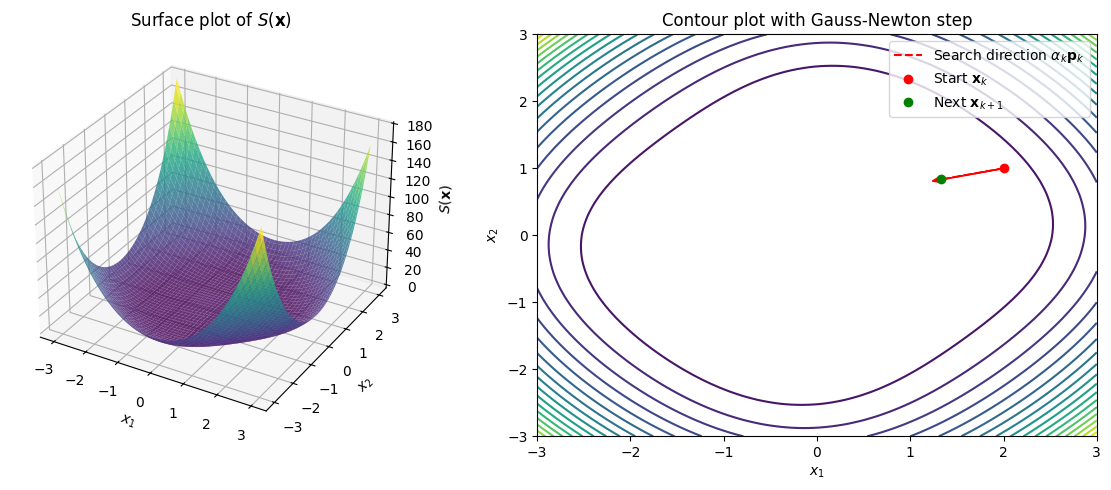

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define F(x) and S(x) = 0.5 * ||F(x)||^2
def F(x):
    return np.array([x[0]**2 + x[1]**2 - 2, x[0]*x[1] - 1])

def S(x):
    return 0.5 * np.sum(F(x)**2)

# Jacobian J(x)
def J(x):
    return np.array([[2*x[0], 2*x[1]],
                     [x[1], x[0]]])

# Gauss-Newton step: solve (J^T J) p = -J^T F
def gauss_newton_step(x_k):
    J_k = J(x_k)
    F_k = F(x_k)
    p_k = np.linalg.solve(J_k.T @ J_k, -J_k.T @ F_k)
    return p_k

# Grid for plotting
x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
s = np.vectorize(lambda x1, x2: S(np.array([x1, x2])))(x1, x2)

# Plot 3D surface (paraboloid-like)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x1, x2, s, cmap='viridis', alpha=0.8)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$S(\mathbf{x})$')
ax1.set_title('Surface plot of $S(\mathbf{x})$')

# Contour plot with step trace
ax2 = fig.add_subplot(122)
ax2.contour(x1, x2, s, levels=20, cmap='viridis')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Contour plot with Gauss-Newton step')

# Starting point and step
x_k = np.array([2.0, 1.0])
p_k = gauss_newton_step(x_k)
alpha_k = 1.0  # Full step
x_next = x_k + alpha_k * p_k

# Trace the vector (arrow from x_k to x_next)
ax2.arrow(x_k[0], x_k[1], alpha_k * p_k[0], alpha_k * p_k[1], head_width=0.1, head_length=0.1, fc='red', ec='red')
ax2.plot([x_k[0], x_next[0]], [x_k[1], x_next[1]], 'r--', label='Search direction $\\alpha_k \\mathbf{p}_k$')
ax2.plot(x_k[0], x_k[1], 'ro', label='Start $\\mathbf{x}_k$')
ax2.plot(x_next[0], x_next[1], 'go', label='Next $\\mathbf{x}_{k+1}$')
ax2.legend()

plt.tight_layout()
plt.show()

For a scalar case (e.g., $f(x) = x^2 - 2$), the plot would be a 2D parabola $s(x) = \frac{1}{2} (x^2 - 2)^2$. The code can be adapted by reducing dimensions.

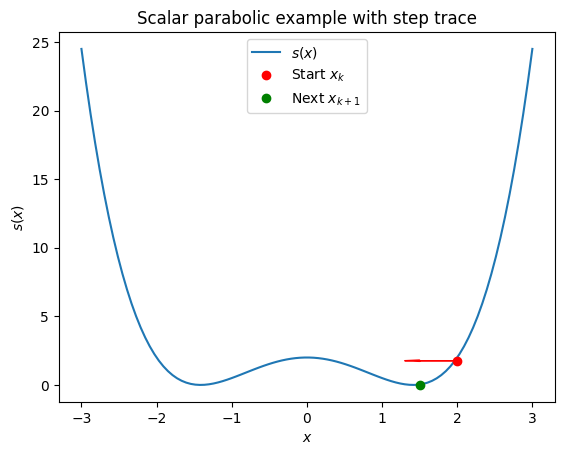

In [87]:
# Scalar example
x_scalar = np.linspace(-3, 3, 100)
f_scalar = x_scalar**2 - 2
s_scalar = 0.5 * f_scalar**2

fig_scalar, ax_scalar = plt.subplots()
ax_scalar.plot(x_scalar, s_scalar, label='$s(x)$')
x_k_scalar = 2.0
p_k_scalar = -(x_k_scalar**2 - 2) / (2 * x_k_scalar)  # Newton step (same as GN in 1D)
alpha_k = 1.0
x_next_scalar = x_k_scalar + alpha_k * p_k_scalar
ax_scalar.arrow(x_k_scalar, s_scalar[np.argmin(np.abs(x_scalar - x_k_scalar))],
                alpha_k * p_k_scalar, 0, head_width=0.1, head_length=0.2, fc='red', ec='red')
ax_scalar.plot(x_k_scalar, s_scalar[np.argmin(np.abs(x_scalar - x_k_scalar))], 'ro', label='Start $x_k$')
ax_scalar.plot(x_next_scalar, s_scalar[np.argmin(np.abs(x_scalar - x_next_scalar))], 'go', label='Next $x_{k+1}$')
ax_scalar.set_xlabel('$x$')
ax_scalar.set_ylabel('$s(x)$')
ax_scalar.set_title('Scalar parabolic example with step trace')
ax_scalar.legend()
plt.show()

##### Geometric interpretation

Geometrically, the Gauss-Newton method approximates the least-squares surface $S(\mathbf{x})$ with a quadratic model at each iteration. The first-order Taylor expansion of $\mathbf{F}$ defines a tangent hyperplane to the residual manifold, but since we minimize $S$, the geometry is on the paraboloid-like surface.
The tangent plane at $\mathbf{x}_k$ to $S(\mathbf{x})$ is the first-order approximation:

$$S(\mathbf{x}_k + \mathbf{\delta}) \approx S(\mathbf{x}_k) + \nabla S(\mathbf{x}_k)^\top \mathbf{\delta}, $$

where $\nabla S = \mathbf{J}^\top \mathbf{F}$. However, Gauss-Newton uses a quadratic approximation $S(\mathbf{x}_k + \mathbf{p}) \approx S(\mathbf{x}_k) + \nabla S(\mathbf{x}_k)^\top \mathbf{p} + \frac{1}{2} \mathbf{p}^\top (\mathbf{J}^\top \mathbf{J}) \mathbf{p}$, minimizing this paraboloid to find $\mathbf{p}_k$.

The Hessian $\mathbf{J}^\top \mathbf{J}$ captures the curvature of this quadratic approximation. The search direction traces a line along the steepest descent on this approximated surface.
To visualize, reuse the 3D plot code above and add the tangent plane (first-order) and quadratic approximation (curved second-order geometry). The tangent plane at $\mathbf{x}_k$ is a flat plane, while the quadratic adds curvature via the Hessian.

<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_404166/2006205119.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax_approx.set_zlabel('$S(\mathbf{x})$')


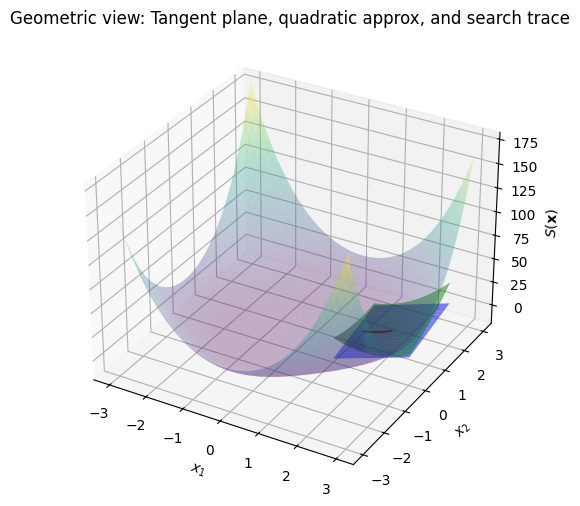

In [88]:
# Extend 3D plot with tangent plane and quadratic approximation
def quadratic_approx(x, x_k):
    J_k = J(x_k)
    F_k = F(x_k)
    grad = J_k.T @ F_k
    hess_approx = J_k.T @ J_k
    delta = x - x_k
    return S(x_k) + grad @ delta + 0.5 * delta.T @ hess_approx @ delta

# Tangent plane (first-order): S(x_k) + grad @ delta
def tangent_plane(x, x_k):
    J_k = J(x_k)
    F_k = F(x_k)
    grad = J_k.T @ F_k
    delta = x - x_k
    return S(x_k) + grad @ delta

# Grid around x_k for approximations
delta1, delta2 = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
approx_x1 = x_k[0] + delta1
approx_x2 = x_k[1] + delta2
tangent = np.vectorize(lambda d1, d2: tangent_plane(np.array([x_k[0]+d1, x_k[1]+d2]), x_k))(delta1, delta2)
quad = np.vectorize(lambda d1, d2: quadratic_approx(np.array([x_k[0]+d1, x_k[1]+d2]), x_k))(delta1, delta2)

# Plot
fig_approx = plt.figure(figsize=(8, 6))
ax_approx = fig_approx.add_subplot(111, projection='3d')
ax_approx.plot_surface(approx_x1, approx_x2, tangent, color='blue', alpha=0.5, label='Tangent plane')
ax_approx.plot_surface(approx_x1, approx_x2, quad, color='green', alpha=0.5, label='Quadratic approx (Hessian curvature)')
ax_approx.plot_surface(x1, x2, s, cmap='viridis', alpha=0.3)  # Full surface faded

# Trace search direction (projected onto the plane)
p_k = gauss_newton_step(x_k)  # From earlier
line_points = np.array([x_k + t * p_k for t in np.linspace(0, 1, 10)])
line_s = np.array([S(pt) for pt in line_points])
ax_approx.plot(line_points[:,0], line_points[:,1], line_s, 'r-', label='Search direction trace')

ax_approx.set_xlabel('$x_1$')
ax_approx.set_ylabel('$x_2$')
ax_approx.set_zlabel('$S(\mathbf{x})$')
ax_approx.set_title('Geometric view: Tangent plane, quadratic approx, and search trace')
plt.show()

Formally, the tangent plane to $S$ at $\mathbf{x}_k$ is the affine hyperplane defined by the first-order Taylor expansion: $\{ (\mathbf{z}, y) \mid y = S(\mathbf{x}_k) + \nabla S(\mathbf{x}_k)^\top (\mathbf{z} - \mathbf{x}_k) \}$, where $\mathbf{z} \in \mathbb{R}^n$. The quadratic approximation adds the Hessian term to capture local curvature, and the search direction minimizes this quadratic along a line.

### 1.5 Full Gauss-Newton Method Demonstration

The full Gauss-Newton method iteratively refines an initial guess $\mathbf{x}_0$ to minimize $S(\mathbf{x}) = \frac{1}{2} \|\mathbf{F}(\mathbf{x})\|^2_2$, effectively solving $\mathbf{F}(\mathbf{x}) = \mathbf{0}$. At each iteration $k$:

1. Compute the Jacobian $\mathbf{J}(\mathbf{x}_k)$ and residual $\mathbf{F}(\mathbf{x}_k)$.
2. Solve the normal equations $\mathbf{J}(\mathbf{x}_k)^\top \mathbf{J}(\mathbf{x}_k) \mathbf{p}_k = -\mathbf{J}(\mathbf{x}_k)^\top \mathbf{F}(\mathbf{x}_k)$ for the search direction $\mathbf{p}_k$.
3. Update $\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \mathbf{p}_k$, where $\alpha_k = 1$ (undamped) or chosen via line search (damped; not implemented here for simplicity).
4. Repeat until convergence, e.g., when $\|\mathbf{x}_{k+1} - \mathbf{x}_k\| <$xtol or a maximum iteration limit is reached.


In [105]:
def solve_gauss_newton(F, J, x0, xtol=1e-6, max_iter=100):
    x_k = np.array(x0, dtype=float)
    for _ in range(max_iter):
        J_k = J(x_k)
        F_k = F(x_k)
        p_k = np.linalg.solve(J_k.T @ J_k, -J_k.T @ F_k)
        x_k_1 = x_k + p_k  # alpha_k = 1.0 (undamped)
        if np.linalg.norm(x_next - x_k) < xtol:
            x_k = x_k_1
            break
        x_k = x_k_1
    return x_k


> ##### Example: Solving a Nonlinear System with Gauss-Newton
> This example uses the undamped version on the system $\mathbf{F}(\mathbf{x}) = [x_0^2 + x_1^2 - 2, x_0 x_1 - 1]^\top = \mathbf{0}$, starting from $\mathbf{x}_0 = [2, 1]^\top$. Convergence is checked on the step size.
> For the code below we also add `gauss_newton` so that we can track the entire path of iterations for visualization.

In [134]:
import numpy as np

def gauss_newton(F, J, x0, xtol=1e-6, max_iter=100):
    x_k = np.array(x0, dtype=float)
    path = [x_k.copy()]  # Store iteration points
    for _ in range(max_iter):
        J_k = J(x_k)
        F_k = F(x_k)
        p_k = np.linalg.solve(J_k.T @ J_k, -J_k.T @ F_k)
        x_next = x_k + p_k  # alpha_k = 1.0 (undamped)
        path.append(x_next.copy())
        if np.linalg.norm(x_next - x_k) < xtol:
            break
        x_k = x_next
    return np.array(path)

# Example
def F(x):
    return np.array([x[0]**2 + x[1]**2 - 2, x[0]*x[1] - 1])

def J(x):
    return np.array([[2*x[0], 2*x[1]],
                     [x[1], x[0]]])


x0 = np.array([2.0, 1.0])
print(f'Solution found: {solve_gauss_newton(F, J, x0)}')
gauss_newton(F, J, x0, xtol=1e-6, max_iter=100)

Solution found: [1.12820513 0.87820513]


array([[2.        , 1.        ],
       [1.33333333, 0.83333333],
       [1.12820513, 0.87820513],
       [1.06250512, 0.93750512],
       [1.03125   , 0.96875   ],
       [1.015625  , 0.984375  ],
       [1.0078125 , 0.9921875 ],
       [1.00390625, 0.99609375],
       [1.00195313, 0.99804687],
       [1.00097656, 0.99902344],
       [1.00048828, 0.99951172],
       [1.00024414, 0.99975586],
       [1.00012207, 0.99987793],
       [1.00006104, 0.99993896],
       [1.00003052, 0.99996948],
       [1.00001526, 0.99998474],
       [1.00000763, 0.99999237],
       [1.00000381, 0.99999619],
       [1.00000191, 0.99999809],
       [1.00000095, 0.99999905],
       [1.00000048, 0.99999952]])

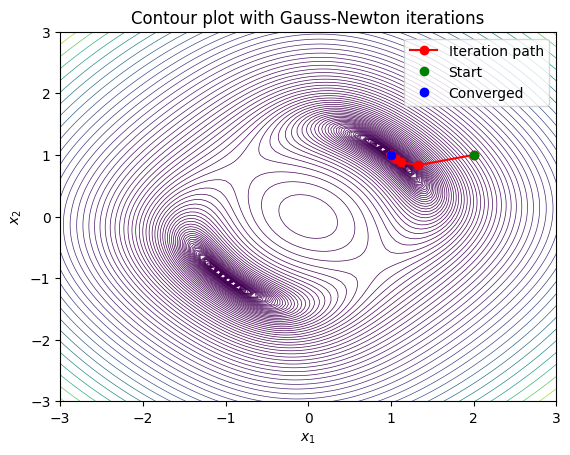

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Run the method (assuming gauss_newton and F are defined as before)
x0 = [2.0, 1.0]
path = gauss_newton(F, J, x0)

# Grid for contour
x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
s = np.vectorize(lambda x1, x2: 0.5 * np.sum(F([x1, x2])**2))(x1, x2)

# Improved levels: logarithmic spacing for better detail near minima
levels = np.logspace(-4, np.log10(s.max() + 1e-10), 100)

# Plot contour with full path
fig, ax = plt.subplots()
ax.contour(x1, x2, s, levels=levels, cmap='viridis', linewidths=0.5)
ax.plot(path[:, 0], path[:, 1], 'r-o', label='Iteration path')
ax.plot(path[0, 0], path[0, 1], 'go', label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', label='Converged')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Contour plot with Gauss-Newton iterations')
ax.legend()
plt.show()

Many numerical methods are directly using this algorithm and are often refered to as quasi-Newton, e.g., Broyden's method refers to simply using the numerical Jacobian in place of the analytical Jacobian in the Gauss-Newton method.

An important large family of methods that build on the Gauss-Newton method are trust region methods, which we will discuss next.

### 1.6 Trust region methods

In order to understand the motivation behind developing trust region methods it is instructive to demonstrate the path taken by the solver if we set $x0 = [0.1, 0.0]$. Note what happens below is that Gauss-Newton takes a very large step that actually increases the residual significantly, and then from there it takes a few more steps to converge to the solution:


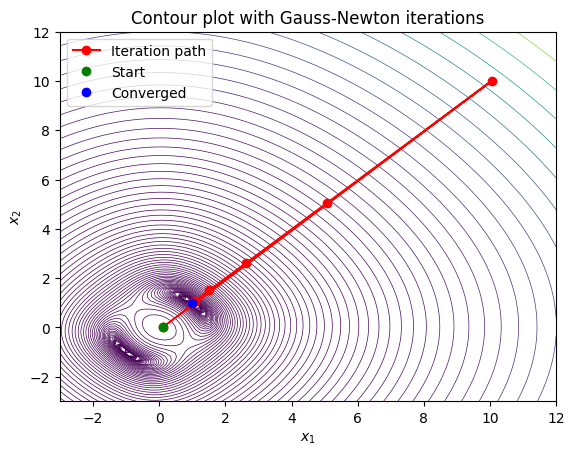

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Run the method (assuming gauss_newton and F are defined as before)
x0 = [0.1, 0.0]
path = gauss_newton(F, J, x0)

# Grid for contour
x1, x2 = np.meshgrid(np.linspace(-3, 12, 100), np.linspace(-3, 12, 100))
s = np.vectorize(lambda x1, x2: 0.5 * np.sum(F([x1, x2])**2))(x1, x2)

# Improved levels: logarithmic spacing for better detail near minima
levels = np.logspace(-4, np.log10(s.max() + 1e-10), 100)

# Plot contour with full path
fig, ax = plt.subplots()
ax.contour(x1, x2, s, levels=levels, cmap='viridis', linewidths=0.5)
ax.plot(path[:, 0], path[:, 1], 'r-o', label='Iteration path')
ax.plot(path[0, 0], path[0, 1], 'go', label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', label='Converged')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Contour plot with Gauss-Newton iterations')
ax.legend()
plt.show()

This behavior is undesirable, and trust region methods are designed to prevent this type of behavior by restricting the step size based on how well the local model approximates the true function. Trust region methods work by defining a "trust region" around the current iterate within which the local model (e.g., the quadratic approximation used in Gauss-Newton) is considered reliable. The step is then chosen to minimize the model within this region, and the size of the trust region is adjusted based on how well the model predicts the actual function behavior.

We can build a very basic version of such a method by simply introducing a step size parameter `alpha` that scales down the Gauss-Newton step. Below is an implementation of such a damped Gauss-Newton method with a fixed step size `alpha = 0.3`:

In [119]:
import numpy as np

def gauss_newton_trust(F, J, x0, alpha=0.3, xtol=1e-6, max_iter=100):
    x_k = np.array(x0, dtype=float)
    path = [x_k.copy()]  # Store iteration points
    for _ in range(max_iter):
        J_k = J(x_k)
        F_k = F(x_k)
        p_k = np.linalg.solve(J_k.T @ J_k, -J_k.T @ F_k)
        x_next = x_k + alpha*p_k  # alpha_k = 1.0 (undamped)
        path.append(x_next.copy())
        if np.linalg.norm(x_next - x_k) < xtol:
            break
        x_k = x_next
    return np.array(path)

x0 = np.array([2.0, 1.0])
gauss_newton_trust(F, J, x0, alpha=0.3, xtol=1e-6, max_iter=100)

array([[2.        , 1.        ],
       [1.8       , 0.95      ],
       [1.63909091, 0.91659091],
       [1.51061278, 0.89648778],
       [1.40865213, 0.88664588],
       [1.32805629, 0.88435098],
       [1.26444675, 0.88729724],
       [1.21420153, 0.89362444],
       [1.17439804, 0.90190752],
       [1.14272574, 0.91110879],
       [1.11738512, 0.92051072],
       [1.09698802, 0.92964477],
       [1.0804686 , 0.93822685],
       [1.06700914, 0.94610365],
       [1.05598072, 0.95321105],
       [1.04689738, 0.95954316],
       [1.03938128, 0.9651302 ],
       [1.03313649, 0.97002307],
       [1.02792942, 0.97428301],
       [1.02357426, 0.97797481],
       [1.01992203, 0.9811625 ],
       [1.01685243, 0.98390683],
       [1.01426764, 0.98626388],
       [1.01208764, 0.98828445],
       [1.0102466 , 0.99001388],
       [1.00869007, 0.99149226],
       [1.00737289, 0.99275475],
       [1.00625738, 0.99383196],
       [1.00531207, 0.99475047],
       [1.00451057, 0.99553321],
       [1.

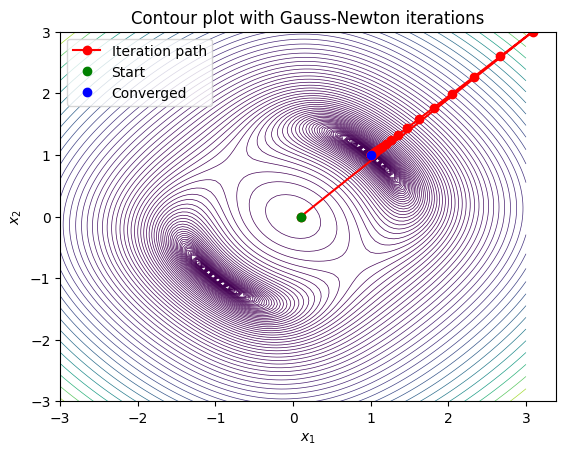

In [120]:
import matplotlib.pyplot as plt
import numpy as np

def gauss_newton_trust(F, J, H, x0, xtol=1e-6, max_iter=100):
    x_k = np.array(x0, dtype=float)
    path = [x_k.copy()]  # Store iteration points
    for _ in range(max_iter):
        J_k = J(x_k)
        F_k = F(x_k)
        p_k = np.linalg.solve(J_k.T @ J_k, -J_k.T @ F_k)
        alpha= []
        x_next = x_k + alpha*p_k  # alpha_k = 1.0 (undamped)
        path.append(x_next.copy())
        if np.linalg.norm(x_next - x_k) < xtol:
            break
        x_k = x_next
    return np.array(path)


# Run the method (assuming gauss_newton and F are defined as before)
x0 = [0.1, 0.0]
path = gauss_newton_trust(F, J, x0, alpha=0.3, xtol=1e-6, max_iter=100)

# Grid for contour
x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
s = np.vectorize(lambda x1, x2: 0.5 * np.sum(F([x1, x2])**2))(x1, x2)

# Improved levels: logarithmic spacing for better detail near minima
levels = np.logspace(-4, np.log10(s.max() + 1e-10), 100)

# Plot contour with full path
fig, ax = plt.subplots()
ax.contour(x1, x2, s, levels=levels, cmap='viridis', linewidths=0.5)
ax.plot(path[:, 0], path[:, 1], 'r-o', label='Iteration path')
ax.plot(path[0, 0], path[0, 1], 'go', label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', label='Converged')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Contour plot with Gauss-Newton iterations')
ax.legend()
plt.show()

This result does not explode outside of the basin of attraction as much, but it is also bad since it requires taking so many steps. In the tutorial we will improve this method using basic information from the residual to adaptively choose the step size `alpha` at each iteration based on how well the model predicts the actual function behavior. For now we demonstrate a simple pseudo trust-region approach that uses the full Hessian of the least-squares objective to compute a damped step.

### Levenberg-Marquardt-like strategy
In standard Gauss-Newton, the full step ($\alpha_k = 1$) may lead to overshooting or divergence in poorly conditioned problems or far from the solution. A pseudo trust-region approach approximates a trust-region constraint by damping the step using a Levenberg-Marquardt-like strategy. Here, we use the full Hessian $\mathbf{H}$ of $S(\mathbf{x})$ (instead of the Gauss-Newton approximation $\mathbf{J}^\top \mathbf{J}$) to compute a damped direction $\mathbf{p}_k$ by solving $(\mathbf{H}_k + \lambda \mathbf{I}) \mathbf{p}_k = -\nabla S_k$, where $\nabla S_k = \mathbf{J}_k^\top \mathbf{F}_k$.
The damping parameter $\lambda$ is adjusted dynamically:

Compute the ratio $\rho = \frac{S(\mathbf{x}_k) - S(\mathbf{x}_k + \mathbf{p}_k)}{-\nabla S_k^\top \mathbf{p}_k - \frac{1}{2} \mathbf{p}_k^\top \mathbf{H}_k \mathbf{p}_k}$ (actual vs. predicted reduction).
If $\rho > 0.1$, accept the step; if $\rho > 0.75$, decrease $\lambda$; else, increase $\lambda$ and retry.

This provides a "pseudo" trust region by controlling step size implicitly through $\lambda$, blending Newton steps (small $\lambda$) with gradient descent (large $\lambda$).
For the example system, we define the full Hessian $\mathbf{H}(\mathbf{x}) = \mathbf{J}^\top \mathbf{J} + \sum_i F_i \mathbf{H}_{f_i}$, where $\mathbf{H}_{f_1} = \begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix}$ and $\mathbf{H}_{f_2} = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$.


In [148]:
import numpy as np

def F(x):
    return np.array([x[0]**2 + x[1]**2 - 2, x[0]*x[1] - 1])

def S(x):
    return 0.5 * np.sum(F(x)**2)

def J(x):
    return np.array([[2*x[0], 2*x[1]],
                     [x[1], x[0]]])

def H(x):
    F_k = F(x)
    hess_f1 = np.array([[2, 0], [0, 2]])
    hess_f2 = np.array([[0, 1], [1, 0]])
    J_k = J(x)
    return J_k.T @ J_k + F_k[0] * hess_f1 + F_k[1] * hess_f2

def gauss_newton_trust(F, J, H, x0, xtol=1e-6, max_iter=100, lambda0=0.1):
    x_k = np.array(x0, dtype=float)
    path = [x_k.copy()]
    lam = lambda0
    for _ in range(max_iter):
        J_k = J(x_k)
        F_k = F(x_k)
        grad = J_k.T @ F_k
        H_k = H(x_k)
        S_k = S(x_k)
        while True:  # Retry with increased lam until accept
            try:
                p_k = np.linalg.solve(H_k + lam * np.eye(len(x_k)), -grad)
            except np.linalg.LinAlgError:
                lam *= 4
                continue
            x_next = x_k + p_k
            S_next = S(x_next)
            actual = S_k - S_next
            predicted = -grad @ p_k - 0.5 * p_k @ (H_k @ p_k)
            if predicted <= 0:
                lam *= 4
                continue
            rho = actual / predicted
            if rho > 0.1:  # Accept step
                path.append(x_next.copy())
                x_k = x_next
                if rho > 0.75:
                    lam = max(lam / 1.5, 1e-10)
                break
            else:  # Reject and increase damping
                lam *= 4
        if np.linalg.norm(p_k) < xtol:
            break
    return np.array(path)

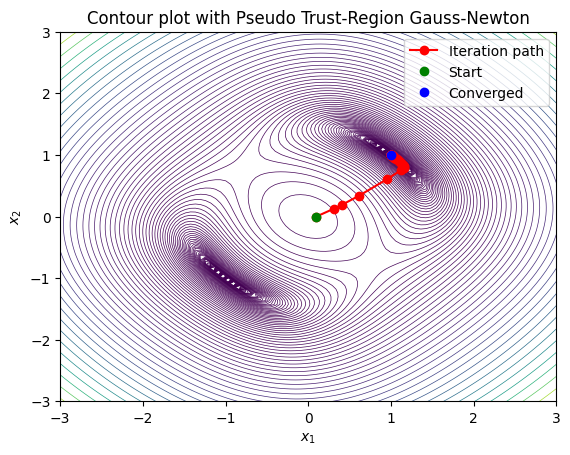

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Run the method
x0 = [0.1, 0.0]
path = gauss_newton_trust(F, J, H, x0)

# Grid for contour
x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
s = np.vectorize(lambda x1, x2: S([x1, x2]))(x1, x2)

# Improved levels: logarithmic spacing for better detail near minima
levels = np.logspace(-4, np.log10(s.max() + 1e-10), 100)

# Plot contour with full path
fig, ax = plt.subplots()
ax.contour(x1, x2, s, levels=levels, cmap='viridis', linewidths=0.5)
ax.plot(path[:, 0], path[:, 1], 'r-o', label='Iteration path')
ax.plot(path[0, 0], path[0, 1], 'go', label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', label='Converged')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Contour plot with Pseudo Trust-Region Gauss-Newton')
ax.legend()
plt.show()

#### Powell's dog leg method (hybrid Newton/minpack)

In Chapters on optimization, we will develop trust region methods in more detail, including Powell's dog leg method, which is a hybrid approach combining the Gauss-Newton step and the steepest descent step within a trust region framework. The scipy implementation of Powell's dog leg method is available via `scipy.optimize.least_squares` with `method='dogbox'`. This method combines the Gauss-Newton step and the steepest descent step within a trust region framework. The dog leg path is determined by the intersection of the trust region boundary and the line segment connecting the Gauss-Newton step and the steepest descent step. As you might expect method performance can be improved by adding an approximation of the gradient information. Example for solving the problem above:


In [143]:
import scipy
# Basic solve:
x0 = np.array([0.1, 0.0])
scipy.optimize.fsolve(F, x0)

array([1., 1.])

In [144]:
# Comparison of performance with and without Jacobian
import numpy as np
from scipy.optimize import fsolve

# Initial guess
x0 = np.array([0.1, 0.0])

# Solve without Jacobian, with full output
sol_without, infodict_without, ier_without, mesg_without = fsolve(F, x0, full_output=True)
print("Solution without Jacobian:", sol_without)
print("Info dict without Jacobian:", infodict_without)
print("Convergence flag (ier):", ier_without)
print("Message:", mesg_without)

# Solve with Jacobian, with full output
sol_with, infodict_with, ier_with, mesg_with = fsolve(F, x0, fprime=J, full_output=True)
print("\nSolution with Jacobian:", sol_with)
print("Info dict with Jacobian:", infodict_with)
print("Convergence flag (ier):", ier_with)
print("Message:", mesg_with)

Solution without Jacobian: [1. 1.]
Info dict without Jacobian: {'nfev': 50, 'fjac': array([[-0.89807106, -0.43985039],
       [ 0.43985039, -0.89807106]]), 'r': array([-2.24468318e+00, -2.24468324e+00,  3.41966155e-08]), 'qtf': array([9.76664061e-17, 1.99411834e-16]), 'fvec': array([0., 0.])}
Convergence flag (ier): 1
Message: The solution converged.

Solution with Jacobian: [1. 1.]
Info dict with Jacobian: {'nfev': 46, 'njev': 2, 'fjac': array([[-0.89807181, -0.43984887],
       [ 0.43984887, -0.89807181]]), 'r': array([-2.24468559e+00, -2.24468566e+00,  3.41258021e-08]), 'qtf': array([9.76660688e-17, 1.99412000e-16]), 'fvec': array([0., 0.])}
Convergence flag (ier): 1
Message: The solution converged.



#### (Optional)  Derivative-Free Methods (e.g., Secant Method as Approximation to Gradient Descent)

For root-finding, gradient descent can be adapted by minimizing the squared residual $g(x) = [f(x)]^2$, where the gradient is $g'(x) = 2 f(x) f'(x)$. However, if $f'(x)$ is unknown, we approximate it (leading to secant-like methods). Here, we frame it as a simple gradient descent on the residual.
##### Algebraic Interpretation
Start with $x_{k+1} = x_k - \alpha \cdot 2 f(x_k) f'(x_k)$ for minimizing $[f(x)]^2$, but for root-finding, it's equivalent to Newton's if $\alpha = 1/(2 f'(x_k))$. For pure gradient descent, use a fixed small $\alpha$.
##### Geometric Interpretation
In 1D, it's stepping downhill on the curve of $[f(x)]^2$, which has minima at roots of $f(x)$. Geometrically, follow the slope toward zero crossings.


### (Optional) Scalar methods
Scalar methods are a special topic applicable to the case where $n=1$ and $m=1$, i.e. solving $f(x)=0$ for a single variable $x$.

#### Bisect method

The bisect method is one of the simplest and most robust root-finding algorithms. It requires an initial interval $[a, b]$ where $f(a)$ and $f(b)$ have opposite signs (i.e., a root exists in the interval by the Intermediate Value Theorem). The method repeatedly bisects the interval and selects the subinterval where the sign change occurs.

##### Algebraic Interpretation
The bisection method halves the interval at each step: compute the midpoint $c = (a + b)/2$. If $f(a) \cdot f(c) < 0$, set $b = c$; otherwise, set $a = c$. Convergence is linear (error halves each step), robust but slow.

##### Geometric Interpretation
Geometrically, it's like repeatedly dividing a line segment where the function crosses zero, zooming in on the root. No derivatives needed, making it derivative-free.


In [125]:
import numpy as np
def f(x):
    return x**2 - 2  # Root at sqrt(2) ≈ 1.414

a, b = 1.0, 2.0  # Initial interval with sign change
c = (a + b) / 2  # Single step
print(f"Midpoint: {c}, f(c): {f(c)}")
# Output: Midpoint: 1.5, f(c): 0.25
# Next interval would be [1.5, 2.0] since f(1.5) > 0 and f(2) > 0? Wait, f(1)= -1, f(1.5)=0.25, so [1,1.5]

Midpoint: 1.5, f(c): 0.25


In [126]:
from scipy.optimize import bisect

root = bisect(f, 1.0, 2.0)
print(f"Root: {root}")
# Output: Root: 1.4142135623715149

Root: 1.4142135623715149


SciPy also offers brentq and brenth, which are faster hybrids combining bisection, secant, and inverse quadratic interpolation.

## Summary of Nonlinear Solvers

These solve  $\mathbf{F(x)} = \mathbf{0}$ where $f_i \in \mathbf{F}$ is a nonlinear scalar function vector-valued function. Principles often build on linear solvers, using approximations like Jacobians for local convergence; global methods handle multiple roots or basins.
1.1 Local Methods (Derivative-Based)

Underlying Principle: Use Taylor expansion or quasi-Newton approximations to iterate toward a root, requiring good initial guesses; quadratic convergence for Newton's method.
Examples:

- Newton-Raphson: Iterates $\mathbf{x}_{k+1} = \mathbf{x}_k - \mathbf{J}^{-1} \mathbf{f(x_k)}$ where $\mathbf{J}$ is the Jacobian; requires Jacobian computation or finite differences.
- Quasi-Newton (e.g., Broyden's): Approximates Jacobian updates without full recomputation; good for expensive Jacobians.
- Levenberg-Marquardt: Hybrid trust-region for least-squares problems (damps Newton steps).
- Dogleg: Combines Gauss-Newton and steepest descent within a trust region (state of the art for nonlinear least squares).


SciPy Availability:

Available:
- scipy.optimize.fsolve (hybrid Newton/minpack; finite-difference Jacobian)
- scipy.optimize.root (supports 'hybr', 'lm', 'broyden1', 'broyden2', 'krylov')
- scipy.optimize.newton (scalar only, secant/Newton).

Not Available: Built-in damped Newton variants or automatic differentiation for Jacobians (use JAX or autograd externally); no native homotopy continuation (e.g., for path-tracking multiple roots).

1.2 Global/Derivative-Free Methods

Underlying Principle: Explore search space without derivatives, using heuristics or sampling; slower but robust to poor initials or multimodality.
Examples:

- Bracketing Methods: Bisection (scalar, interval-based), Brent's (hybrid secant/bisection).
- Population-Based: Genetic algorithms, particle swarm (evolutionary; for global roots).
 -Trust-Region Dogleg: For unconstrained nonlinear equations.


SciPy Availability:

Available:
- scipy.optimize.root (with 'df-sane' for derivative-free spectral)
- scipy.optimize.brentq/brenth (scalar bracketing)
- scipy.optimize.minimize (can adapt for root-finding via optimization, e.g., 'powell' or 'nelder-mead').


Not Available:

- Built-in evolutionary/global methods like differential evolution for pure root-finding (though scipy.optimize.differential_evolution exists for optimization); no interval arithmetic solvers (e.g., for guaranteed enclosures; use pyinterval).

## 2. Linear Solvers
These solve $\mathbf{Ax} = \mathbf{b}$ where $\mathbf{A}$ is a matrix, $\mathbf{x}$ is the unknown vector, and $\mathbf{b}$ is a known vector. Principles include factorization (direct) or successive approximations (iterative), with considerations for matrix properties (e.g., sparse, symmetric, positive definite) to ensure stability and efficiency. Of course we can always subtract the right hand side of the equation to recast it as $\mathbf{F(x)} = \mathbf{Ax} - \mathbf{b} = \mathbf{0} $ and use nonlinear solvers , but this is not efficient for large systems. A very rich field of numerical linear algebra has been developed to efficiently solve such systems. To begin with it is useful to understand the geometric interpretation of such systems to understand what the solvers are doing in terms

> #### Example: Geometric Interpretation: Intersecting Planes
>
> A system of three linear equations in three variables can be visualized as three planes in 3D space. The solution $\mathbf{x}$ is the point where all three planes intersect (if unique). For example, consider the system:
> $$x + y + z = 3, \quad 2x - y + z = 2, \quad x + 2y - z = 1.$$
> The planes intersect at a single point $(1, 1, 1)$.
> Below is Python code to plot these planes and their intersection.

> A system of three linear equations in three variables can be visualized as three planes in 3D space. The solution $\mathbf{x}$ is the point where all three planes intersect (if unique). Each linear equation, corresponding to a row of the system $\mathbf{Ax} = \mathbf{b}$, defines a hyperplane $h(\mathbf{x}) = \mathbf{a}_i^T \mathbf{x} - b_i = 0$, where $\mathbf{a}_i$ is the i-th row of $\mathbf{A}$. In 3D space, these hyperplanes are planes, and the solution is their intersection point.
> For example, consider the system:
>
> $$\mathbf{A} = \begin{bmatrix} 1 & 1 & 1 \\ 2 & -1 & 1 \\ 1 & 2 & -1 \end{bmatrix}, \quad \mathbf{b} = \begin{bmatrix} 3 \\ 2 \\ 2 \end{bmatrix},$$
> which corresponds to the equations:
>
> $$x_1 + x_2 + x_3 = 3, \quad 2x_1 - x_2 + x_3 = 2, \quad x_1 + 2x_2 - x_3 = 2.$$
>
> The planes intersect at a single point $(1, 1, 1)$. Below is Python code to plot these planes and their intersection.

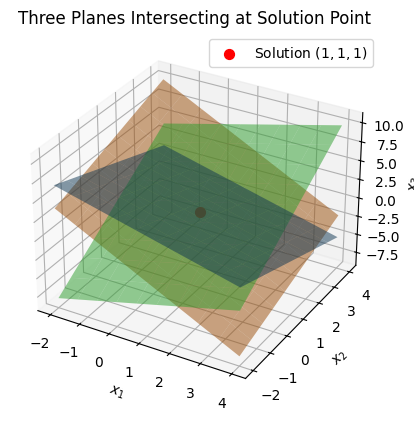

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the planes: a x1 + b x2 + c x3 = d
planes = [
    (1, 1, 1, 3),   # x1 + x2 + x3 = 3
    (2, -1, 1, 2),  # 2x1 - x2 + x3 = 2
    (1, 2, -1, 2)   # x1 + 2x2 - x3 = 2
]

# Solve the system to find intersection point
A = np.array([[1, 1, 1], [2, -1, 1], [1, 2, -1]])
b = np.array([3, 2, 2])
sol = np.linalg.solve(A, b)

# Grid for plotting
xx1, xx2 = np.meshgrid(np.linspace(-2, 4, 10), np.linspace(-2, 4, 10))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each plane
for a, b, c, d in planes:
    if c != 0:
        xx3 = (d - a*xx1 - b*xx2) / c
    else:
        xx3 = np.zeros_like(xx1)  # Fallback, though not needed here
    ax.plot_surface(xx1, xx2, xx3, alpha=0.5)

# Plot intersection point
ax.scatter(*sol, color='red', s=50, label='Solution $(1,1,1)$')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Three Planes Intersecting at Solution Point')
ax.legend()
plt.show()

###  2.1 Direct Methods

Direct methods are the simplest way to think about how to solve linear systems. For example if you have the scalar equation $2x = 4$ you can directly solve for $x$ by dividing both sides by 2 to get $x = 2$. In the case of linear systems the idea is similar, but we use matrix factorizations to decompose the matrix into simpler forms that can be solved exactly in a finite number of steps. Essentially we want to find the inverse of the matrix $\mathbf{A}$ such that $\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}$. However, computing the inverse directly is often not the most efficient or stable way to solve the system, so we use factorizations instead.

Underlying Principle: Decompose the matrix into factors (e.g., triangular) for exact solution in finite steps, assuming no round-off errors. Efficient for dense matrices of moderate size; sensitive to conditioning and pivoting for numerical stability.
Examples:

#### 2.1.1 Gaussian Elimination / LU Decomposition:
Factorizes $\mathbf{A} = \mathbf{LU}$ (lower/upper triangular), solves via forward/backward substitution. Partial pivoting (PLU) improves stability.

scipy.linalg.solve (general direct solver using LAPACK (Linear Algebra PACKage); handles LU internally), scipy.linalg.lu (explicit LU with pivoting),


The SciPy command for this decomposition is linalg.lu. Such a decomposition is often useful for solving many simultaneous equations where the left-hand side does not change but the right-hand side does. For example, suppose we are going to solve


### 2.1.2 Finding the inverse

In SciPy, the matrix inverse of the NumPy array, A, is obtained using linalg.inv (A), or using A.I if A is a Matrix. For example, let

The following example demonstrates this computation in SciPy

#### 2.1.3 Cholesky Decomposition:
For symmetric positive definite matrices, $\mathbf{A} = \mathbf{LL}^T$ or $\mathbf{UU}^T$; faster than LU (about half the operations).

#### 2.1.4 QR Decomposition:
Orthogonal factorization $\mathbf{A} = \mathbf{QR}$; useful for least-squares or underdetermined systems.

#### 2.1.5 Singular Value Decomposition (SVD):

$\mathbf{A} = \mathbf{U\Sigma V}^T$; handles ill-conditioned or rectangular matrices, provides pseudo-inverse.

#### 2.1.6  band-matrix solvers

Available: scipy.linalg.solve (general direct solver using LAPACK; handles LU internally), scipy.linalg.lu (explicit LU with pivoting), scipy.linalg.cholesky, scipy.linalg.qr, scipy.linalg.svd.
Not Available: Built-in band-matrix solvers (though scipy.linalg.solve_banded exists for banded systems); no native parallel direct solvers (use external libraries like PETSc).

### 2.1.7 Condition exception handling

ill-conditioning (check with numpy.linalg.cond)


In [150]:
import numpy
import numpy as np
from scipy import linalg

# Example matrix (slightly modified to avoid singularity)
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 10]])

# Compute SVD: Returns U, singular values S (as vector), and Vt (V transpose)
U, S, Vt = linalg.svd(A)

# Display results
print("U matrix:")
print(U)
print("\nSingular values:")
print(S)
print("\nVt matrix:")
print(Vt)

# Reconstruct A to verify (U * diag(S) * Vt)
reconstructed_A = np.dot(U, np.dot(np.diag(S), Vt))
print("\nReconstructed A:")
print(np.round(reconstructed_A, decimals=10))  # Round for floating-point precision

U matrix:
[[-0.20933734  0.96438514  0.16167618]
 [-0.50384851  0.03532145 -0.86306956]
 [-0.8380421  -0.26213299  0.47850992]]

Singular values:
[17.41250517  0.87516135  0.19686652]

Vt matrix:
[[-0.46466755 -0.55375455 -0.69097031]
 [-0.83328635  0.00949949  0.55275999]
 [ 0.2995295  -0.83262576  0.46585022]]

Reconstructed A:
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8. 10.]]


In practice, for solving systems, you might use the pseudo-inverse from SVD for least-squares: pinv_A = np.dot(Vt.T, np.dot(np.diag(1/S), U.T))

In [151]:
pinv_A = np.dot(Vt.T, np.dot(np.diag(1/S), U.T))
pinv_A

array([[-0.66666667, -1.33333333,  1.        ],
       [-0.66666667,  3.66666667, -2.        ],
       [ 1.        , -2.        ,  1.        ]])

In [152]:
import timeit
import numpy

A = np.random.rand(50, 50)
A

array([[0.44075   , 0.98249207, 0.94659941, ..., 0.21909111, 0.71756407,
        0.37278052],
       [0.934822  , 0.34621449, 0.72141708, ..., 0.3464767 , 0.45470819,
        0.48187852],
       [0.0908987 , 0.92312896, 0.3947625 , ..., 0.74326775, 0.56710929,
        0.36308123],
       ...,
       [0.86326717, 0.30955054, 0.29068962, ..., 0.77288521, 0.28153912,
        0.25612784],
       [0.32271158, 0.02754482, 0.06196574, ..., 0.94650184, 0.97025787,
        0.42811098],
       [0.9375563 , 0.99740028, 0.07837619, ..., 0.92210822, 0.40648049,
        0.8481224 ]], shape=(50, 50))

In [153]:
#numpy.invert(A)
%timeit -n1000 numpy.linalg.inv(A)

36.5 μs ± 644 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [154]:
%timeit  -n1000  U, S, Vt = linalg.svd(A)#, np.dot(Vt.T, np.dot(np.diag(1/S), U.T))

425 μs ± 88.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



### 2.2 Iterative Methods

Underlying Principle: Start with an initial guess and refine iteratively until convergence (e.g., residual below tolerance). Ideal for large sparse systems; convergence depends on preconditioning and matrix spectrum.

Examples:
#### 2.2.1 Stationary Methods: Jacobi (diagonal dominance),
Splits $\mathbf{A} = \mathbf{D} + \mathbf{R}$ (diagonal + remainder); updates $\mathbf{x}^{k+1} = \mathbf{D}^{-1} (\mathbf{b} - \mathbf{R x}^k)$. Converges for diagonally dominant matrices.

#### 2.2.2 Gauss-Seidel (updates in-place),
Similar to Jacobi but uses latest updates immediately for faster convergence in suitable systems.

#### 2.2.3  Successive Over-Relaxation (SOR; accelerates with relaxation parameter).
Extends Gauss-Seidel with over-relaxation factor $\omega > 1$; optimal $\omega$ speeds convergence but requires tuning.

#### 2.2.4 Krylov Subspace Methods: Conjugate Gradient (CG; for symmetric positive definite),
Projects onto Krylov subspaces; minimizes quadratic form; efficient for large SPD matrices.

#### 2.2.5 Generalized Minimal Residual (GMRES; for nonsymmetric),
Minimizes residual in Krylov subspace using Arnoldi iteration; robust for nonsymmetric systems.

#### 2.2.6 Biconjugate Gradient Stabilized (BiCGSTAB).
Stabilizes BiCG for irregular convergence; effective for nonsymmetric, indefinite matrices.

#### 2.2.7 Multigrid Methods: Hierarchical smoothing and coarsening for elliptic PDEs (e.g., geometric/algebraic multigrid).
Uses multi-level grids to accelerate convergence by handling low/high-frequency errors separately.

#### 2.2.8 Jacobi/Gauss-Seidel/SOR

The Gauss-Seidel method is an iterative technique for solving systems of linear equations $\mathbf{Ax} = \mathbf{b}$, where $\mathbf{A}$ is an $n \times n$ square matrix, $\mathbf{x}$ is the unknown vector, and $\mathbf{b}$ is the known right-hand side vector. It is particularly useful for large, sparse systems where direct methods (like LU decomposition) may be computationally expensive. The method assumes $\mathbf{A}$ is diagonally dominant or positive definite to ensure convergence, though it can work in other cases with proper preconditioning.

Unlike direct methods, which compute an exact solution in finite steps (barring round-off errors), Gauss-Seidel refines an initial guess iteratively until the solution converges within a specified tolerance. It improves upon the Jacobi method by using the most recent updates immediately, which often leads to faster convergence.

##### Mathematical Formulation

Consider the system:

$$\mathbf{Ax} = \mathbf{b},$$

where $\mathbf{A} = [a_{ij}]$, $\mathbf{x} = [x_1, x_2, \dots, x_n]^\top$, and $\mathbf{b} = [b_1, b_2, \dots, b_n]^\top$.
We decompose $\mathbf{A}$ implicitly as $\mathbf{A} = \mathbf{D} + \mathbf{L} + \mathbf{U}$, where:

$\mathbf{D}$ is the diagonal matrix ($d_{ii} = a_{ii}$),
$\mathbf{L}$ is the strictly lower triangular part,
$\mathbf{U}$ is the strictly upper triangular part.

The Gauss-Seidel iteration solves for each component $x_i^{(k+1)}$ using:

$$x_i^{(k+1)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij} x_j^{(k)} \right),$$

for $i = 1, 2, \dots, n$, where superscript $(k)$ denotes the iteration number. This uses newly computed values (from the current iteration) for the lower terms and old values for the upper terms.
The iteration continues until the change in $\mathbf{x}$ is small, e.g., $\|\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}\| < tol$.

##### Convergence Conditions

Diagonal Dominance: The method converges if $\mathbf{A}$ is strictly diagonally dominant, i.e., $|a_{ii}| > \sum_{j \neq i} |a_{ij}|$ for all $i$.
Symmetric Positive Definite (SPD): Guaranteed convergence for SPD matrices.
Spectral Radius: More generally, convergence if the spectral radius of the iteration matrix is less than 1.
In practice, check residuals or use a maximum iteration limit to avoid infinite loops.

If the method diverges, consider relaxation (e.g., Successive Over-Relaxation, SOR) or preconditioning.

##### Algorithm Steps:

1. Initialize: Start with an initial guess $\mathbf{x}^{(0)}$ (often $\mathbf{0}$) and set iteration counter $k = 0$.
2. Update Components: For each $i = 1$ to $n$:
3. Compute the sum of already updated lower terms: $\sum_{j=1}^{i-1} a_{ij} x_j^{(k+1)}$.
4. Compute the sum of old upper terms: $\sum_{j=i+1}^{n} a_{ij} x_j^{(k)}$.
5. Update: $x_i^{(k+1)} = \frac{1}{a_{ii}} \left( b_i - \text{lower sum} - \text{upper sum} \right)$.
6. Check Convergence: Compute $\|\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}\|$. If below $tol$, stop; else, set $k = k+1$ and repeat.
7. Termination: Stop after max iterations if not converged (raise error or warn).

> Example: Basic Gauss-Seidel Algorithm
>The Gauss-Seidel method iteratively solves $\mathbf{Ax} = \mathbf{b}$ by updating each component using the latest values. Here's a simple Python implementation for a general square system.

In [156]:
import numpy as np

def gauss_seidel(A, b, x0=None, tol=1e-6, max_iter=1000):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    for iter in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            s = b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i+1:], x_old[i+1:])
            x[i] = s / A[i, i]
        if np.linalg.norm(x - x_old) < tol:
            return x, iter + 1
    raise ValueError("Gauss-Seidel did not converge")

# Example usage
A = np.array([[4, -1, 0], [-1, 4, -1], [0, -1, 4]])
b = np.array([2, 3, 2])
x, iterations = gauss_seidel(A, b)
print("Solution:", x)
print("Iterations:", iterations)

Solution: [0.78571425 1.14285713 0.78571428]
Iterations: 9


## 3. (Optional) Special-Purpose Solvers
These handle structured problems beyond standard linear/nonlinear, often integrating with the above.

### 3.1 Eigenvalue Solvers

Underlying Principle: Find $\lambda, \mathbf{v}$ such that $\mathbf{A v} = \lambda \mathbf{v}$; uses iterations like power method or QR algorithm.
Examples: Standard eigenvalue, generalized ($\mathbf{A v} = \lambda \mathbf{B v}$).
SciPy Availability: Available (scipy.linalg.eig, scipy.linalg.eigh for Hermitian, scipy.sparse.linalg.eigs for sparse).

### 3.2 Least-Squares Solvers

Underlying Principle: Minimize $\|\mathbf{Ax} - \mathbf{b}\|^2$; uses SVD or normal equations.
Examples: Linear (LSQR), nonlinear (curve_fit).
SciPy Availability: Available (scipy.linalg.lstsq, scipy.optimize.least_squares, scipy.optimize.curve_fit).

### 3.3 Sparse and Large-Scale Extensions

Underlying Principle: Exploit sparsity to reduce storage/computation; iterative with preconditioners.
SciPy Availability: Strong support via scipy.sparse and scipy.sparse.linalg; missing: Advanced algebraic multigrid (use PyAMG).

e.g., using scipy.linalg.solve for linear systems in Unit 4 (Simulation I – algebraic systems). Include caveats like ill-conditioning (check with numpy.linalg.cond).
What SciPy Excels At: Dense linear algebra and basic nonlinear root-finding; efficient for engineering-scale problems (<10^4 variables).
Limitations and Alternatives: For very large/sparse systems, PETSc or SuiteSparse; for symbolic Jacobians, integrate SymPy (available in the environment). Avoid over-reliance on SciPy for production HPC.

## Further reading

### Historical papers and sources
-  Yale Babylonian Collection (YBC) 7289 (Old Babylonian period, circa 1800–1600 BCE). This cuneiform tablet approximates √2 using an iterative method. (Artifact; not a "paper." Modern analysis: Fowler, D. H., & Robson, E. (1998). "Square Root Approximations in Old Babylonian Mathematics: YBC 7289 in Context." Historia Mathematica, 25(4), 366–378.)
- Hero of Alexandria. Metrica (circa 60 CE). Book I describes the iterative method for square roots. (Greek manuscript; discovered in 1896 by Richard Schöne in Istanbul. Modern edition: Schöne, R. (Ed.). (1903). Heronis Alexandrini opera quae supersunt omnia, Vol. III: Metrica. Teubner, Leipzig. English translation: Bruins, E. M. (1964). Codex Constantinopolitanus Palatii Veteris No. 1, Part 3. Brill, Leiden.)
- Newton, I. (1669/1711). "De analysi per aequationes numero terminorum infinitas" [On the analysis of equations unlimited in the number of their terms]. Written in 1669; first published in Analysis per quantitatum series, fluxiones, ac differentias (Ed. W. Jones). London: Pearson, 1711, pp. 1–32.
- Raphson, J. (1690). Analysis aequationum universalis [Universal analysis of equations]. London: Typis T. Braddyll prostant venales apud Georgium Sawbridge.
- Gauss, C. F. (1809). Theoria motus corporum coelestium in sectionibus conicis solem ambientium [Theory of the motion of the heavenly bodies moving about the sun in conic sections]. Hamburg: F. Perthes et I. H. Besser. (Book; the method appears in Book II, Section III. English translation: Davis, C. H. (Trans.). (1857). Theory of the Motion of the Heavenly Bodies Moving about the Sun in Conic Sections. Little, Brown and Company, Boston.)
- Seidel, Ludwig (1874). "Über ein Verfahren, die Gleichungen, auf welche die Methode der kleinsten Quadrate führt, sowie lineäre Gleichungen überhaupt, durch successive Annäherung aufzulösen" [On a process for solving by successive approximation the equations to which the method of least squares leads as well as linear equations generally]. Abhandlungen der Mathematisch-Physikalischen Klasse der Königlich Bayerischen Akademie der Wissenschaften (in German). 11 (3): 81–108.
- Halley, E. (1694). "Methodus nova accurata et facilis inveniendi radices æquationum quarumcumque generaliter, sine prævia reductione" [A new, exact, and easy method of finding the roots of equations generally, and that without any previous reduction]. Philosophical Transactions of the Royal Society, 18(209), 136–148. (Latin; English translation available in modern reprints. Digitized via JSTOR or Royal Society archives.)
- Levenberg, K. (1944). "A Method for the Solution of Certain Non-Linear Problems in Least Squares." Quarterly of Applied Mathematics, 2(2), 164–168. (Published while at Frankford Army Arsenal; digitized via AMS or JSTOR.)
- Powell, M. J. D. (1970). "A Hybrid Method for Nonlinear Equations." In P. Rabinowitz (Ed.), Numerical Methods for Nonlinear Algebraic Equations (pp. 87–114). London: Gordon and Breach. (Chapter in edited volume; digitized via academic libraries or SpringerLink in later reprints.)
- Moré, J. J., Garbow, B. S., & Hillstrom, K. E. (1980). "User Guide for MINPACK-1." Argonne National Laboratory Report ANL-80-74. Argonne, IL: Argonne National Laboratory. (Technical report; includes algorithms like Powell's hybrid. Digitized via Netlib or Argonne's repository.)